# Neural Networks - Deep Learning

## Second Assignment - Multiclass Classification using Support Vector Machines
### Dimitrios Tikvinas AEM: 9998

# Introduction

In this assignment we are going to implement multiple SVM models in order to efficiently perform multiclass classification in the well-known and significant in the field of computer vision dataset **CIFAR-10**. It is consisted of 60000 **32x32 colour**(*RGB, meaning 3 color channel*) images  in **10** classes, with **6000 images per class**(*equalized*).

It is of paramount importance to identify the strengths and weaknesses of different models used, so that we become able to work towards the ultimate one for our dataset.

Throughout our project, we will make predictions on the test set ONLY for educational purposes, since we want to leave the test set untouched and unknown up until the final evaluation of the ultimate model we produce.

## SVM

**Support Vector Machines** (SVMs) are supervised learning models used for classification and regression tasks. That's why we chose them to handle our multiclass image classification task. 

They aim to find the hyperplane that best separates the data points of different classes while maximizing the margin between them.

The margin is the distance between the hyperplane and the nearest data point of any class. SVM seeks to maximize this margin to improve generalization to new, unseen data.

Support vectors are the data points that lie closest to the decision boundary.
They play a crucial role in determining the optimal hyperplane.

SVMs can use a kernel function to transform the input data into a higher-dimensional space, allowing for non-linear decision boundaries.

## Imports

In [1]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt

from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV

## Load the CIFAR-10 dataset

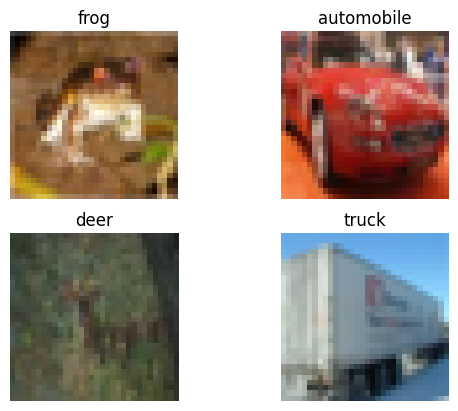

In [2]:
# Load CIFAR-10 dataset
(X_train, Y_train), (X_test, Y_test) = tf.keras.datasets.cifar10.load_data()

# Define class labels as strings for CIFAR-10
class_labels = [
    'airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'
]


num_classes = 10 # total classes


# Display some CIFAR-10 images
plt.subplot(221)
plt.imshow(X_train[0])
plt.axis('off')
plt.title(class_labels[Y_train[0][0]])
plt.subplot(222)
plt.imshow(X_train[5])
plt.axis('off')
plt.title(class_labels[Y_train[5][0]])
plt.subplot(223)
plt.imshow(X_train[10])
plt.axis('off')
plt.title(class_labels[Y_train[10][0]])
plt.subplot(224)
plt.imshow(X_train[15])
plt.axis('off')
plt.title(class_labels[Y_train[15][0]])
plt.show()

# Convert to float32 array for easier management
X_train, X_test = np.array(X_train, dtype=np.float32), np.array(X_test, dtype=np.float32)

# Keep the original CIFAR-10 images untouched
X_train_un, X_test_un = X_train, X_test



### Feature Engineering Technique 1: Data Augmentation

The process of applying random transformations on the input images and use them alongside the original ones for the ultimate model's training helps improve the generalization and robustness of the SVM model. This is accomplished by the increase in the diversity provided by the wider range of examples, by making the model less likely to memorize specific instances and learn features that generalize well to unseen data and , specifically for SVMs, due to their inherent lack of translation invariance, by learning features that are more invariant to shifts.


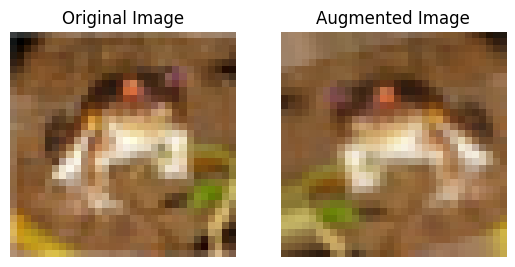

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Dimensionality expansion to make Data augmentation possible
X_train_aug = np.expand_dims(X_train_un, axis=0)  
X_test_aug = np.expand_dims(X_test_un, axis=0)  

# Create ImageDataGenerator
datagen = ImageDataGenerator(
    rotation_range=20,  
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=False,
    zoom_range=0.2
)

# Apply random transformation 
X_train_aug_un = np.array([datagen.apply_transform(image, datagen.get_random_transform(image.shape)) for image in X_train_un])

# To visualize the augmented image
import matplotlib.pyplot as plt

plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(X_train_un[0].astype(np.uint8))  # Convert back to uint8 for display
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Augmented Image')
plt.imshow(X_train_aug_un[0].astype(np.uint8))
plt.axis('off')

plt.show()


### Data Preprocessing : Normalization and PCA 

We apply normalization on the images in order to improve the convergence of the optimization algorithms that are sensitive to the scale of input features, for numerical stability of the gradients and equalized influence among the features.

On the other hand, we apply PCA in order to reduce the dimensionality of the dataset's images, them having a high one of 32x32x3 = 3072, while preserving the most important information. This way, we decrease the computational cost of learning, reduce noise by shifting the model's attention to the most significant patterns in the data and achieve higher memory efficiency

In [4]:

#Normalize pixel values to be between 0 and 1
X_train, X_train_aug, X_test= (X_train_un / 255.0 ), (X_train_aug_un / 255.0 ), (X_test_un / 255.0 )

# Flatten the images to be 1-D vectors
X_train, X_train_aug, X_test = X_train.reshape(X_train.shape[0], -1), X_train_aug.reshape(X_train.shape[0], -1), \
                                                    X_test.reshape(X_test.shape[0], -1)



# Show dimension for each variable
print ('Train image shape:    {0}'.format(X_train.shape))
print ('Train label shape:    {0}'.format(Y_train.shape))
print ('Test image shape:     {0}'.format(X_test.shape))
print ('Test label shape:     {0}'.format(Y_test.shape))

# Apply PCA on the features in order to reduce their dimensionality
print(f'Features before PCA :  {X_train[0].shape[0]}')
pca = PCA(n_components=0.9).fit(X_train)
X_train_pca = pca.transform(X_train)
X_train_aug_pca = pca.transform(X_train_aug)
X_test_pca = pca.transform(X_test)
print(f'Features before PCA : {X_train_pca[0].shape[0]}')


Train image shape:    (50000, 3072)
Train label shape:    (50000, 1)
Test image shape:     (10000, 3072)
Test label shape:     (10000, 1)
Features before PCA :  3072
Features before PCA : 99


### Feature Engineering Technique 2: Histogram of Oriented Gradients (HOG) 

We are to apply this feature extraction technique on the CIFAR-10 images. It has proven to be effective in object recognition due to its local gradient information capture. Moreover, HOG is inherently invariant to translation and scale changes, which means that it can make the SVM model perform even better on unseen data of a real-world application. Also, due to its computational efficiency compared to other feature extraction techniques and its tendency to work well for objects with discernible shapes and textures, such as CIFAR-10, it has high potential to be a valuable feature engineering process.

In [5]:
from skimage.feature import hog as HOG
from skimage import exposure
import numpy as np

def compute_hog_features(image):
    features, _ = HOG(image, orientations=8, pixels_per_cell=(6, 6), cells_per_block=(1, 1), visualize=True, channel_axis=-1)
    return features

# Applying HOG on the original images
X_train_hog = np.array([compute_hog_features(image) for image in X_train_un])
X_train_aug_hog = np.array([compute_hog_features(image) for image in X_train_aug_un])
X_test_hog = np.array([compute_hog_features(image) for image in X_test_un])


# Applying PCA on the features in order to reduce their dimensionality
print(f'Features before PCA :  {X_train_hog[0].shape[0]}')
pca = PCA(n_components=0.9).fit(X_train_hog)
X_train_hog_pca = pca.transform(X_train_hog)
X_train_aug_hog_pca = pca.transform(X_train_aug_hog)
X_test_hog_pca = pca.transform(X_test_hog)
print(f'Features before PCA : {X_train_hog_pca[0].shape[0]}')


Features before PCA :  200
Features before PCA : 142


In [6]:
# Gathering the features from PCA and HOG together
X_train_combined_pca = np.concatenate((X_train_pca, X_train_hog_pca), axis=1) 
X_train_aug_combined_pca = np.concatenate((X_train_aug_pca, X_train_aug_hog_pca), axis=1) 
X_test_combined_pca = np.concatenate((X_test_pca, X_test_hog_pca), axis=1) 

Here we concatenated the pixel values after normalization and applied PCA with the HOG extracted features after the also applied PCA. The procedure we are about to follow is check which kernel function performs the best on the CIFAR-10 with features only the transformed pixel values, and then we will evaluate whether the addition of the HOG features provided any further improvement. 

Due to the dataset's size, we will use only a fraction to perform the important grid search for each kernel function to determine which one outperforms the rest. Due to the random selection of images from the train set, we can safely guarantee that the grid search will be able to detect the best hyperparameter's values for each kernel.

In [7]:
# Set the fraction to use for the grid-search
fraction_to_take = 0.3

# Calculate the number of elements to take based on the fraction
num_elements_to_take = int(len(X_train_pca) * fraction_to_take)

# Generate random indices to select elements
random_indices = np.random.choice(len(X_train_pca), size = num_elements_to_take, replace=False)

# Take a fraction of the original array using the random indices
X_train_pca_fraction = X_train_pca[random_indices]
Y_train_fraction = Y_train[random_indices]

## SVM - Linear Kernel

The linear kernel function is given by the equation:

$$
K(w, b) = w^{T}x + b
$$

We will check how effective the linear kernel can be when it has to deal with images. Are they linear separable data? Can a simple kernel function as this one perform sufficiently well?

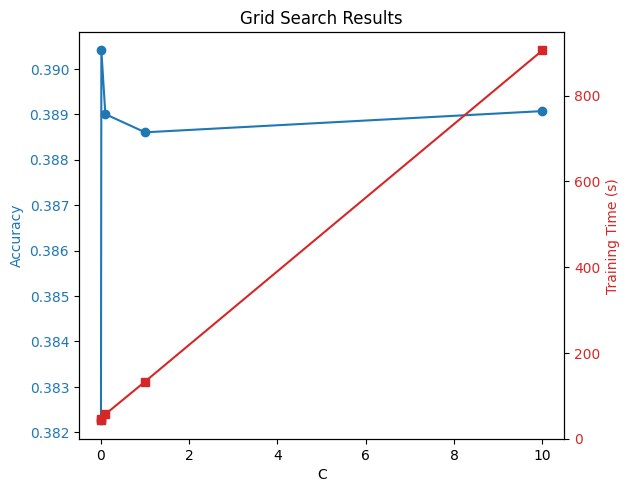

Best Parameters: {'C': 0.01}
Best Accuracy: 0.39039999999999997


In [8]:
from sklearn import svm
import sys

param_grid = {'C': [0.001, 0.01, 0.1, 1, 10]}

# Create an SVM model with a linear kernel
svc_linear = svm.SVC(probability = False, kernel = 'linear')

# Perform grid search
grid_search_linear = GridSearchCV(svc_linear, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_linear.fit(X_train_pca_fraction, Y_train_fraction.ravel())


# Get the grid search results
results = grid_search_linear.cv_results_
params = results['params']
c_values = [param['C'] for param in params]
mean_test_scores = results['mean_test_score']
fit_times = results['mean_fit_time']

# Plotting
fig, ax1 = plt.subplots()

# Plot accuracy
color = 'tab:blue'
ax1.set_xlabel('C')
ax1.set_ylabel('Accuracy', color=color)
ax1.plot(c_values, mean_test_scores, color=color, marker='o')
ax1.tick_params(axis='y', labelcolor=color)

# Create a second y-axis to plot training time
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Training Time (s)', color=color)
ax2.plot(c_values, fit_times, color=color, marker='s')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title('Grid Search Results')
plt.show()

print("Best Parameters:", grid_search_linear.best_params_)
print("Best Accuracy:", grid_search_linear.best_score_)


### Predict the test set using the best parameter from GridSearch

In [9]:
import time

svc_linear_best = svm.SVC(probability = False, kernel = 'linear', C = grid_search_linear.best_params_.get('C'))

start_time = time.time()
svc_linear_best.fit(X_train_pca, Y_train.ravel())
end_time = time.time()
print(f'Training time :  {end_time - start_time :.2f} s')

Y_pred_train = svc_linear_best.predict(X_train_pca)
Y_pred_test = svc_linear_best.predict(X_test_pca)

test_accuracy = accuracy_score(Y_test, Y_pred_test)
train_accuracy = accuracy_score(Y_train, Y_pred_train)
print(f'Accuracy on train set :  {train_accuracy :.2f} %')
print(f'Accuracy on test set :  {test_accuracy :.2f} %')


Training time :  398.44 s
Accuracy on train set :  0.42 %
Accuracy on test set :  0.41 %


The accuracies on the train and test sets are more like the same, meaning that the model didn't overfit the training data. However, we aren't satisfied with its perfomance.

## SVM - Polynomial Kernel

The polynomial kernel function is given by the equation:

$$
K(w, x) = (\gamma w^{T}x + b) ^ {N}
$$

Polynomial kernels allow SVMs to capture non-linear relationships in the data by transforming the input features into higher-dimensional spaces. Most of the times, images exhibit non-linear patterns and structures. By balancing bias and variance through the choice of the polynomial degree (d), we will try to achieve better perfomance than the linear kernel.

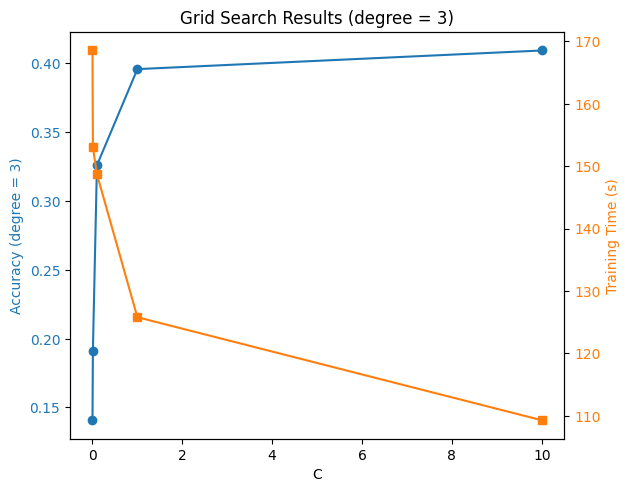

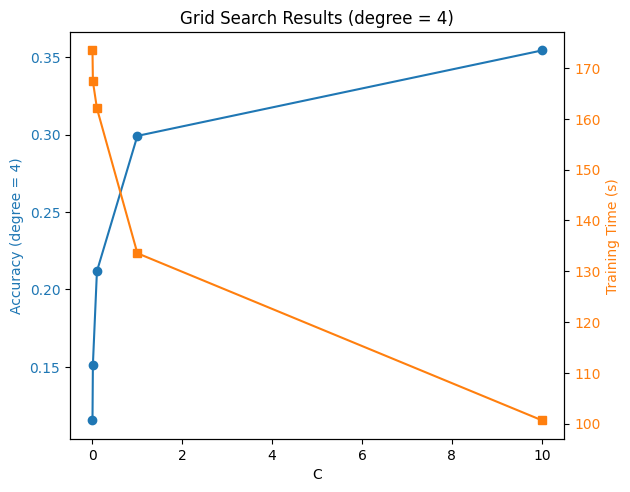

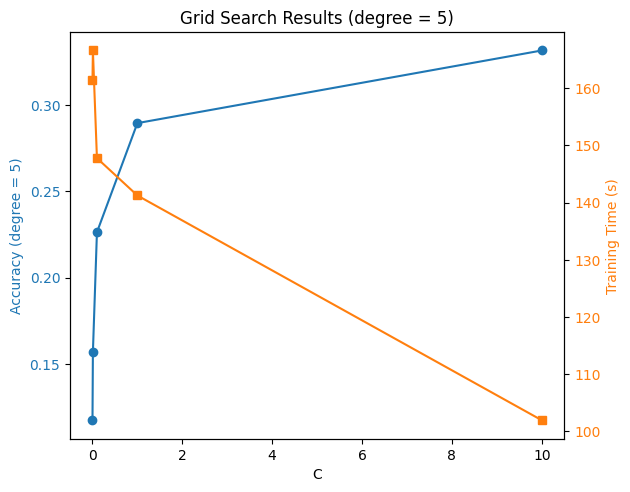

Best Parameters: {'C': 10, 'degree': 3}
Best Accuracy: 0.40939999999999993


In [10]:

param_grid = {'C': [0.001, 0.01, 0.1, 1, 10], 
              'degree': [3, 4, 5],}

# Create an SVM model with a linear kernel
svc_poly = svm.SVC(probability = False, kernel = 'poly')

# Perform grid search
grid_search_poly = GridSearchCV(svc_poly, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_poly.fit(X_train_pca_fraction, Y_train_fraction.ravel())


# Get the grid search results
results = grid_search_poly.cv_results_
params = results['params']
mean_test_scores = results['mean_test_score']
fit_times = results['mean_fit_time']

# Filter results for degree = 3
indices_3 = [i for i, param in enumerate(params) if param['degree'] == 3]
c_values_3 = [param['C'] for i, param in enumerate(params) if i in indices_3]
accuracies_3 = [mean_test_scores[i] for i in indices_3]
fit_times_3 = [fit_times[i] for i in indices_3]

# Filter results for degree = 4
indices_4 = [i for i, param in enumerate(params) if param['degree'] == 4]
c_values_4 = [param['C'] for i, param in enumerate(params) if i in indices_4]
accuracies_4 = [mean_test_scores[i] for i in indices_4]
fit_times_4 = [fit_times[i] for i in indices_4]

# Filter results for degree = 5
indices_5 = [i for i, param in enumerate(params) if param['degree'] == 5]
c_values_5 = [param['C'] for i, param in enumerate(params) if i in indices_5]
accuracies_5 = [mean_test_scores[i] for i in indices_5]
fit_times_5 = [fit_times[i] for i in indices_5]

# Plotting for degree = 3
fig, ax1 = plt.subplots()

# Plot accuracy for degree = 3
color = 'tab:blue'
ax1.set_xlabel('C')
ax1.set_ylabel('Accuracy (degree = 3)', color=color)
ax1.plot(c_values_3, accuracies_3, color=color, marker='o')
ax1.tick_params(axis='y', labelcolor=color)

# Create a second y-axis to plot training time for degree = 3
ax2 = ax1.twinx()
color = 'tab:orange'
ax2.set_ylabel('Training Time (s)', color=color)
ax2.plot(c_values_3, fit_times_3, color=color, marker='s')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title('Grid Search Results (degree = 3)')
plt.show()

# Plotting for degree = 4
fig, ax1 = plt.subplots()

# Plot accuracy for degree = 4
color = 'tab:blue'
ax1.set_xlabel('C')
ax1.set_ylabel('Accuracy (degree = 4)', color=color)
ax1.plot(c_values_4, accuracies_4, color=color, marker='o')
ax1.tick_params(axis='y', labelcolor=color)

# Create a second y-axis to plot training time for degree = 4
ax2 = ax1.twinx()
color = 'tab:orange'
ax2.set_ylabel('Training Time (s)', color=color)
ax2.plot(c_values_4, fit_times_4, color=color, marker='s')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title('Grid Search Results (degree = 4)')
plt.show()

# Plotting for degree = 5
fig, ax1 = plt.subplots()

# Plot accuracy for degree = 5
color = 'tab:blue'
ax1.set_xlabel('C')
ax1.set_ylabel('Accuracy (degree = 5)', color=color)
ax1.plot(c_values_5, accuracies_5, color=color, marker='o')
ax1.tick_params(axis='y', labelcolor=color)

# Create a second y-axis to plot training time for degree = 4
ax2 = ax1.twinx()
color = 'tab:orange'
ax2.set_ylabel('Training Time (s)', color=color)
ax2.plot(c_values_5, fit_times_5, color=color, marker='s')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title('Grid Search Results (degree = 5)')
plt.show()

print("Best Parameters:", grid_search_poly.best_params_)
print("Best Accuracy:", grid_search_poly.best_score_)

It seems that the polynomial kernel didn't perform in the cross-validation subset any better than the linear one. Let's check its accuracy on the test set now.

### Predict the test set using the best parameters from GridSearch

In [11]:
svc_poly_best = svm.SVC(probability = False, kernel = 'poly', C = grid_search_poly.best_params_.get('C'))

start_time = time.time()
svc_poly_best.fit(X_train_pca, Y_train.ravel())
end_time = time.time()
print(f'Training time :  {end_time - start_time :.2f} s')
Y_pred_train = svc_poly_best.predict(X_train_pca)
Y_pred_test = svc_poly_best.predict(X_test_pca)

test_accuracy = accuracy_score(Y_test, Y_pred_test)
train_accuracy = accuracy_score(Y_train, Y_pred_train)
print(f'Accuracy on train set :  {train_accuracy :.2f} %')
print(f'Accuracy on test set :  {test_accuracy :.2f} %')

Training time :  268.27 s
Accuracy on train set :  0.88 %
Accuracy on test set :  0.48 %


## SVM - RBF Kernel

The Gaussian RBF kernel function is given by the equation:

$$
K(x, y) = e^{-\frac{\|x - y\|^2}{2\sigma^2}}
$$

The RBF kernel, as the polynomial one, allows SVMs to model non-linear decision boundaries. Its high flexibility, robustness to outliers and ability on handling irregularly shaped clusters compared to the linear kernel makes them capable of capturing complex patterns and structures in data such as the CIFAR-10. Let's see if all that plays out.

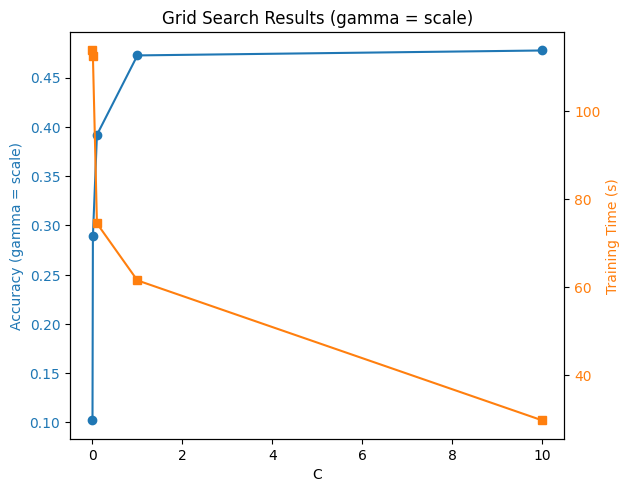

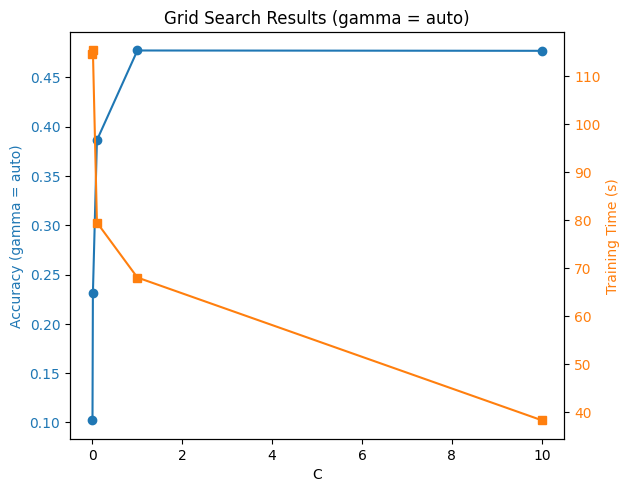

Best Parameters: {'C': 10, 'gamma': 'scale'}
Best Accuracy: 0.4775333333333333


In [12]:

param_grid = {'C': [0.001, 0.01, 0.1, 1, 10],
              'gamma': ['auto', 'scale']}


svc_rbf = svm.SVC(probability = False, kernel = 'rbf')

# Perform grid search
grid_search_rbf = GridSearchCV(svc_rbf, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_rbf.fit(X_train_pca_fraction, Y_train_fraction.ravel())


# Get the grid search results
results = grid_search_rbf.cv_results_
params = results['params']
mean_test_scores = results['mean_test_score']
fit_times = results['mean_fit_time']

# Filter results for gamma = 'scale'
scale_indices = [i for i, param in enumerate(params) if param['gamma'] == 'scale']
scale_c_values = [param['C'] for i, param in enumerate(params) if i in scale_indices]
scale_accuracies = [mean_test_scores[i] for i in scale_indices]
scale_fit_times = [fit_times[i] for i in scale_indices]

# Filter results for gamma = 'auto'
auto_indices = [i for i, param in enumerate(params) if param['gamma'] == 'auto']
auto_c_values = [param['C'] for i, param in enumerate(params) if i in auto_indices]
auto_accuracies = [mean_test_scores[i] for i in auto_indices]
auto_fit_times = [fit_times[i] for i in auto_indices]

# Plotting for gamma = 'scale'
fig, ax1 = plt.subplots()

# Plot accuracy for gamma = 'scale'
color = 'tab:blue'
ax1.set_xlabel('C')
ax1.set_ylabel('Accuracy (gamma = scale)', color=color)
ax1.plot(scale_c_values, scale_accuracies, color=color, marker='o')
ax1.tick_params(axis='y', labelcolor=color)

# Create a second y-axis to plot training time for gamma = 'scale'
ax2 = ax1.twinx()
color = 'tab:orange'
ax2.set_ylabel('Training Time (s)', color=color)
ax2.plot(scale_c_values, scale_fit_times, color=color, marker='s')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title('Grid Search Results (gamma = scale)')
plt.show()

# Plotting for gamma = 'auto'
fig, ax1 = plt.subplots()

# Plot accuracy for gamma = 'auto'
color = 'tab:blue'
ax1.set_xlabel('C')
ax1.set_ylabel('Accuracy (gamma = auto)', color=color)
ax1.plot(auto_c_values, auto_accuracies, color=color, marker='o')
ax1.tick_params(axis='y', labelcolor=color)

# Create a second y-axis to plot training time for gamma = 'auto'
ax2 = ax1.twinx()
color = 'tab:orange'
ax2.set_ylabel('Training Time (s)', color=color)
ax2.plot(auto_c_values, auto_fit_times, color=color, marker='s')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title('Grid Search Results (gamma = auto)')
plt.show()

print("Best Parameters:", grid_search_rbf.best_params_)
print("Best Accuracy:", grid_search_rbf.best_score_)

### Predict the test set using the best parameters from GridSearch

In [13]:
svc_rbf_best = svm.SVC(probability = False, kernel = 'rbf', C = grid_search_rbf.best_params_.get('C'), gamma = grid_search_rbf.best_params_.get('gamma'))

start_time = time.time()
svc_rbf_best.fit(X_train_pca, Y_train.ravel())
end_time = time.time()
print(f'Training time :  {end_time - start_time :.2f} s')
Y_pred_train = svc_rbf_best.predict(X_train_pca)
Y_pred_test = svc_rbf_best.predict(X_test_pca)

test_accuracy = accuracy_score(Y_test, Y_pred_test)
train_accuracy = accuracy_score(Y_train, Y_pred_train)
print(f'Accuracy on train set :  {train_accuracy :.2f} %')
print(f'Accuracy on test set :  {test_accuracy :.2f} %')

Training time :  181.86 s
Accuracy on train set :  0.92 %
Accuracy on test set :  0.56 %


## SVM - Sigmoid Kernel

The Sigmoid kernel function is given by the equation:

$$
K(x, y) = \tanh(\alpha x \cdot y + c)
$$

We include this kernel function mostly for thoroughness, since it can be useful in special cases where other kernels may not perform as well due to the necessity of a sigmoidal activation function  

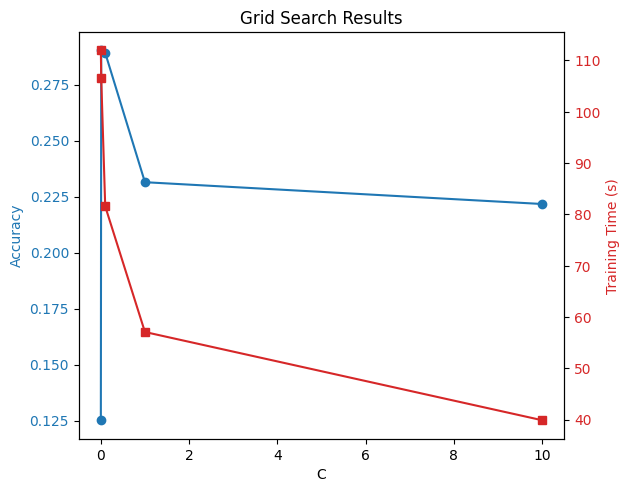

Best Parameters: {'C': 0.01}
Best Accuracy: 0.2902


In [14]:

param_grid = {'C': [0.001, 0.01, 0.1, 1, 10]}


svc_rbf = svm.SVC(probability = False, kernel = 'sigmoid')

# Perform grid search
grid_search_sigmoid = GridSearchCV(svc_rbf, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_sigmoid.fit(X_train_pca_fraction, Y_train_fraction.ravel())


# Get the grid search results
results = grid_search_sigmoid.cv_results_
params = results['params']
c_values = [param['C'] for param in params]
mean_test_scores = results['mean_test_score']
fit_times = results['mean_fit_time']

# Plotting
fig, ax1 = plt.subplots()

# Plot accuracy
color = 'tab:blue'
ax1.set_xlabel('C')
ax1.set_ylabel('Accuracy', color=color)
ax1.plot(c_values, mean_test_scores, color=color, marker='o')
ax1.tick_params(axis='y', labelcolor=color)

# Create a second y-axis to plot training time
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Training Time (s)', color=color)
ax2.plot(c_values, fit_times, color=color, marker='s')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title('Grid Search Results')
plt.show()

print("Best Parameters:", grid_search_sigmoid.best_params_)
print("Best Accuracy:", grid_search_sigmoid.best_score_)

### Predict the test set using the best parameters from GridSearch

In [15]:
svc_sigmoid_best = svm.SVC(probability = False, kernel = 'sigmoid', C = grid_search_sigmoid.best_params_.get('C'))

start_time = time.time()
svc_sigmoid_best.fit(X_train_pca, Y_train.ravel())
end_time = time.time()
print(f'Training time :  {end_time - start_time :.2f} s')
Y_pred_train = svc_sigmoid_best.predict(X_train_pca)
Y_pred_test = svc_sigmoid_best.predict(X_test_pca)

test_accuracy = accuracy_score(Y_test, Y_pred_test)
train_accuracy = accuracy_score(Y_train, Y_pred_train)
print(f'Accuracy on train set :  {train_accuracy :.2f} %')
print(f'Accuracy on test set :  {test_accuracy :.2f} %')



Training time :  256.19 s
Accuracy on train set :  0.31 %
Accuracy on test set :  0.32 %


# Best SVM kernel function  

Below we gathered the best parameters for each kernel function, the training time and the accuracies for the train and test set to determine which is the best configuration for our SVM model on the CIFAR-10 dataset. The features we used for the above grid searches where the images' pixel values after Normalization and PCA.

Model  | Hyperparameters | Training time | Train Accuracy Score | Test Accuracy Score | 
-------------------|------------------|-------|-------|-------|
Linear SVM       | C = 0.01  | 398.44 s  | 0.42 | 0.41
Polynomial SVM      | C = 10, degree = 3 |  268.27 s | 0.88 | 0.48
**RBF SVM** | **C = 10, gamma = scale** | **181.86 s**  | **0.92** | **0.56**
Sigmoid SVM | C = 0.01 |  256.19 s | 0.31 | 0.32

From the above metrics we can conclude that the images are non-linearly separable due to the inefficiency of the Linear SVM. The RBF kernel seems to recognize the patterns and structures of the CIFAR-10 images the most. However, the drawback is the overfitting on the training data, which can be countered with the addition of the HOG features or/ and the addition of the augmented data. Moreover, the Sigmoid Kernel SVM had better accuracy on the test set compared to the train one, meaning that it underfitted the training data.

## RBF-SVM on HOG features

We will now check how the selected RBF kernel performs  on HOG extracted features instead of the pixels' values.

In [16]:
svc_rbf_best = svm.SVC(probability = False, kernel = 'rbf', C = grid_search_rbf.best_params_.get('C'), gamma = grid_search_rbf.best_params_.get('gamma'))

start_time = time.time()
svc_rbf_best.fit(X_train_hog_pca, Y_train.ravel())
end_time = time.time()

print(f'Training time :  {end_time - start_time :.2f} s')
Y_pred_train = svc_rbf_best.predict(X_train_hog_pca)
Y_pred_test_svm_rbf = svc_rbf_best.predict(X_test_hog_pca) # used later for examples of predictions

test_accuracy = accuracy_score(Y_test, Y_pred_test_svm_rbf)
train_accuracy = accuracy_score(Y_train, Y_pred_train)
print(f'Accuracy on train set :  {train_accuracy :.2f} %')
print(f'Accuracy on test set :  {test_accuracy :.2f} %')

Training time :  373.31 s
Accuracy on train set :  1.00 %
Accuracy on test set :  0.57 %


Even though the accuracy on the test set was a little bit higher when using the HOG features, the model overfitted the training data completely, meaning that the HOG features aren't the optimal standalone selection for the features. However, their high perfomance indicates that they could be useful enough. That's why we suggest that we combine the pixels' values with the HOG features into one and see what occurs.

## RBF-SVM on HOG features on top of the initial data

In [17]:
svc_rbf_best = svm.SVC(probability = False, kernel = 'rbf', C = grid_search_rbf.best_params_.get('C'), gamma = grid_search_rbf.best_params_.get('gamma'))

start_time = time.time()
svc_rbf_best.fit(X_train_combined_pca, Y_train.ravel())
end_time = time.time()

print(f'Training time :  {end_time - start_time :.2f} s')
Y_pred_train = svc_rbf_best.predict(X_train_combined_pca)
Y_pred_test_svm_rbf = svc_rbf_best.predict(X_test_combined_pca) # used later for examples of predictions

test_accuracy = accuracy_score(Y_test, Y_pred_test_svm_rbf)
train_accuracy = accuracy_score(Y_train, Y_pred_train)
print(f'Accuracy on train set :  {train_accuracy :.2f} %')
print(f'Accuracy on test set :  {test_accuracy :.2f} %')

Training time :  349.79 s
Accuracy on train set :  0.96 %
Accuracy on test set :  0.64 %


Features  | Training time | Train Accuracy Score | Test Accuracy Score | 
-------------------|------------------|-------|-------|
pixels         | 181.86 s  | 0.98 | 0.56
HOG        | 373.31 s  | 1.00 | 0.57
**pixels + HOG**     | **349.79 s** | **0.96** | **0.64** | 

We see that even though the HOG features tackled the problem of absolute overfitting, their combination with the initial data actually increased the accuracy on the test set and lowered the train accuracy score.

## Data augmentation for SVM with RBF Kernel

Let's see if the data augmentation could further improve our model's perfomance

In [18]:
X_train_all_pca = np.concatenate([X_train_combined_pca, X_train_aug_combined_pca], axis = 0)
Y_train_all = np.concatenate([Y_train, Y_train], axis = 0)

In [19]:
svc_rbf_best = svm.SVC(probability = False, kernel = 'rbf', C = grid_search_rbf.best_params_.get('C'), gamma = grid_search_rbf.best_params_.get('gamma'))

start_time = time.time()
svc_rbf_best.fit(X_train_all_pca, Y_train_all.ravel())
end_time = time.time()

print(f'Training time :  {end_time - start_time :.2f} s')
Y_pred_train = svc_rbf_best.predict(X_train_combined_pca)
Y_pred_test = svc_rbf_best.predict(X_test_combined_pca)

test_accuracy = accuracy_score(Y_test, Y_pred_test)
train_accuracy = accuracy_score(Y_train, Y_pred_train)
print(f'Accuracy on train set :  {train_accuracy :.2f} %')
print(f'Accuracy on test set :  {test_accuracy :.2f} %')
# 417 s, 0.5, 0.63 train, 0.58 test

Training time :  7418.75 s
Accuracy on train set :  0.95 %
Accuracy on test set :  0.64 %


Features  | Training time | Train Accuracy Score | Test Accuracy Score | 
-------------------|------------------|-------|-------|
**pixels + HOG**        | **349.79 s**  | **0.96** | **0.64**
pixels + HOG + data augmentation      | 7418.75 s | 0.95 | 0.64

For only a neglectable decrease in the train accuracy we paid the price for training the RBF-SVM model including also the augmented data of x 21 training time. It is no way worth it. So we stick the features being the **pixels' values** and the **HOG extracted features**.  

# kNN and Nearest Centroid Classifiers for comparison

For the sake of comparison, we will fit some simple models to our dataset using the **kNN** and the **Nearest Centroid** classifiers. 

## 1-Nearest Neighbors Classifier

In [20]:
from sklearn.neighbors import KNeighborsClassifier, NearestCentroid

# Number of nearest neighbors
k = 1

# Initialize the K-Nearest Neighbors classifier
knn_1 = KNeighborsClassifier(n_neighbors=k)

# Start the timer
start = time.time()

# Train the K-Nearest Neighbors model on the training data
knn_1.fit(X_train_combined_pca, Y_train.ravel())

# Stop the timer
end = time.time()

print("Training time: {}s\n".format(end-start))

# Make predictions on the test data
Y_pred = knn_1.predict(X_test_combined_pca)

# Calculate and store the accuracy of the model on both train and test set
accuracy_train = accuracy_score(knn_1.predict(X_train_combined_pca), Y_train.ravel())
accuracy_test = accuracy_score(Y_pred, Y_test)

print(f'Accuracy on train set: {accuracy_train:.2f}')
print(f'Accuracy on test set: {accuracy_test:.2f}')

Training time: 0.008324861526489258s

Accuracy on train set: 1.00
Accuracy on test set: 0.40


## 3-Nearest Neighbors Classifier

We increase the number of nearest neighbors from 1 to 3.

In [21]:
# Number of nearest neighbors
k = 3

# Initialize the K-Nearest Neighbors classifier
knn_3 = KNeighborsClassifier(n_neighbors=k)

# Start the timer
start = time.time()

# Train the K-Nearest Neighbors model on the training data
knn_3.fit(X_train_combined_pca, Y_train.ravel())

# Stop the timer
end = time.time()

print("Training time: {}s\n".format(end-start))

# Make predictions on the test data
Y_pred = knn_3.predict(X_test_combined_pca)

# Calculate and store the accuracy of the model on both train and test set
accuracy_train = accuracy_score(knn_3.predict(X_train_combined_pca), Y_train.ravel())
accuracy_test = accuracy_score(Y_pred, Y_test)

print(f'Accuracy on train set: {accuracy_train:.2f}')
print(f'Accuracy on test set: {accuracy_test:.2f}')

Training time: 0.012951850891113281s

Accuracy on train set: 0.64
Accuracy on test set: 0.39


## Nearest Centroid Classifier

In [22]:
# Initialize the Nearest Centroid classifier
ncc = NearestCentroid()

# Start the timer
start = time.time()

# Train the Nearest Centroid model on the training data
ncc.fit(X_train_combined_pca, Y_train.ravel())

# Stop the timer
end = time.time()

print("Training time: {}s\n".format(end-start))

# Make predictions on the test data
Y_pred = ncc.predict(X_test_combined_pca)

# Calculate and store the accuracy of the model on both train and test set
accuracy_train = accuracy_score(ncc.predict(X_train_combined_pca), Y_train.ravel()) 
accuracy_test = accuracy_score(Y_pred, Y_test)

print(f'Accuracy on train set: {accuracy_train:.2f}')
print(f'Accuracy on test set: {accuracy_test:.2f}')

Training time: 0.035088300704956055s

Accuracy on train set: 0.27
Accuracy on test set: 0.28


# Final Conclusions

Model  |  Training time | Train Accuracy Score | Test Accuracy Score | 
-------------------|------------------|-------|-------|
RBF SVM       | **349.79 s**  | **0.96** | **0.64** 
1-NN Classifier     | 0.008 s |  1.00 | 0.4 
3-NN Classifier | 0.013 s | 0.64  | 0.39  
Nearest Centroid Classifier | 0.035 s | 0.27 | 0.28 

Even though the training times of the simple classifiers were significantly lower than the SVM's training time, their accuracies on the test data are far worse, marking the **RBF-SVM** model the best option out of the 4 mentioned.

## Examples of Correct and False predictions 

We will show some examples of valid and false classification, to understand how a real world application would look and function like.

Printing examples of valid classification:


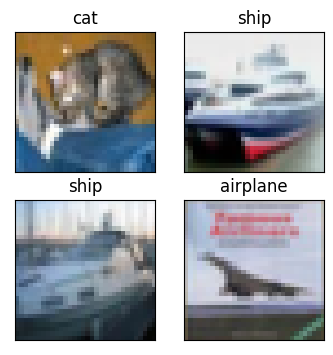

Printing examples of false classification:


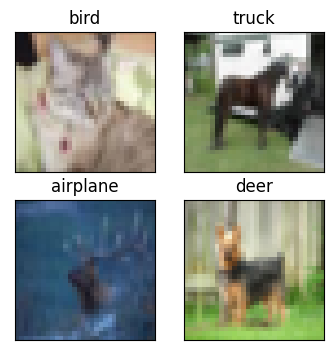

In [23]:
print('Printing examples of valid classification:')
printed = 0
fig = plt.figure(figsize=(4,4))
for i in range (0, Y_test.shape[0]):
    if Y_test[i] == Y_pred_test_svm_rbf[i]:
        ax = fig.add_subplot(2, 2, printed + 1, xticks=[], yticks=[])
        ax.title.set_text(class_labels[Y_pred_test_svm_rbf[i]])
        ax.imshow((X_test_un[i, :]).astype(int))
        printed += 1
    if printed == 4:
        printed = 0
        break
plt.show()
print('Printing examples of false classification:')
fig2 = plt.figure(figsize=(4,4))
for i in range (0, Y_test.shape[0]):
    if Y_test[i] !=  Y_pred_test_svm_rbf[i]:
        ax2 = fig2.add_subplot(2, 2, printed + 1, xticks=[], yticks=[])
        ax2.title.set_text(class_labels[Y_pred_test_svm_rbf[i]])
        ax2.imshow((X_test_un[i, :]).astype(int))
        printed += 1
    if printed == 4:
        break
plt.show()